<a href="https://colab.research.google.com/github/pietroventurini/machine-learning-notes/blob/master/3%20-%20Decision%20Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Learning
### Contents
1. **[Introduction](#Introduction)**  
    1.1 Classification vs Regression trees  
2. **[Building a decision tree](#Building-a-decision-tree)**  
3. **[Impurity indexes](#Impurity-indexes)** *(How to choose the best split)*  
    3.1. Entropy  
    3.2. Information gain  
    3.3. Gain ratio  
    3.4. Gini index  
    3.5. Classification error rate
4. **[Main issues](#Main-issues)**  
    4.1. How to select the feature to split?  
    4.2. How to perform the split?  
    4.3. How to handle continuous valued attributes?  
    4.4. How to deal with noisy data?  
    4.5. How to handle missing values?  
    4.6. How to avoid overfitting?  
5. **[Decision trees in `scikit-learn`](#Decision-Trees-in-scikit-learn)**
6. **[Random forests](#Random-forests)**

# Introduction
Decision tree learning is a predictive modeling approach that makes use of a **decision tree** to go from *observations* of an item (represented in the branches) to *conclusions* about the item's target value (represented in the leaves). If the target variable (i.e. the variable we want to predict) is discrete (e.g. a boolean value, a qualitative feature...), then we'll talk about **classification trees**, while if it can take continuous values (e.g. the price of a house, or a patient's length of stay in a hospital), then we'll talk about **regression trees**.

The decision tree model learns a series of questions to infer the class labels of the examples. When we want to classify a new data entry, starting from the root we go through the tree by asking a question at every branch node (a node internal to the tree) and, according to the answer to that question, by walking the path that is consistent with such answer (it will be clearer in the next section: *Classification vs Regression trees*). The leaf node that will be reached, will determine the entry's predicted target value.

But, **how can we build a learning tree?**
Roughly speaking, starting from the root, we split the data on the feature (i.e. on the variable) that results in the largest **information gain** (more on that later). We can repeat the splitting procedure at each child node until the leaves are *pure* (i.e. they contain only training examples with the same target value).
In order to avoid **overfitting**, caused by a tree that is too deep, we typically want to ***prune*** the tree by limiting its maximal depth. 

Problems that are appropriate for decision trees are problems in which:
- instances are represented by **(attribute, value) pairs**
- target function has **discrete output value**
- instances described by **binary or nominal attributes**
- **disjunctive descriptions** may be required
- training data may contain **errors** or **missing attribute's values**

### Advantages of  decision tree algorithms
- Do not require any prior assumption on the probability distribution of the data.
- Inexpensive to construct (can handle big training sets).
- Fast at classifying new instances (they just have to traverse the tree from the root to a leaf node making a comparison at each intermediate node).
- They are easily interpretable (and so they are usable in context in which a rational justification of the made choice is required).
- They are robust with respect to the presence of noisy data.

## Classification vs Regression trees
### Classification trees
**Classification trees** are models in which the target variable can take a *discrete set of values*. For example consider the task of recommending apps to users, based on data from the following dataset:

| Gender | Occupation |    App (target)   |
|:------:|:----------:|:---------:|
|    F   |   Student  | Instagram |
|    F   |   Worker   |  WhatsApp |
|    M   |   Worker   |  Snapchat |
|    F   |   Worker   |  WhatsApp |
|    M   |   Student  | Instagram |
|    M   |   Student  | Instagram |

Based on that data we can answer some questions:
- For a woman who works at an office, which app do we recommend? *WhatsApp*
- For a man who works at a factory, which app do we recommend? *Snapchat*
- For a girl who goes to high school, which app do we recommend? *Instagram*

And observe that, between our features, `gender` and `occupation`, `occupation` seems more decisive for predicting what app the users will download, indeed, from our data, we can see that the students all downloaded Instagram. We can therefore build a decision tree where to all the students we will recommend Instagram while to the workers we will make a recommendation based on their gender: Whatsapp to the female workers, and Snapchat to the male ones.

Input variables can take continuous values. For example, consider task of determining if a student will be selected from a University, based on its average grade and on the result obtained in an admission test. This is a **binary classification problem** (target = Yes/No).

Let the dataset be the following:

<img alt="grades dataset" src="images/decision_trees/grades_split_1.png" style="display: block; margin-left: auto; margin-right: auto; width:20em"/>

Now we ask ourselves what is the feature between `grades` and `test` that better splits our dataset into students that will be admitted, and students who don't. In other words, between a horizontal and a vertical line, which one would cuts the data better? A vertical line in `test = 5`  will do a better job, so we have identified our first branch in the decision tree.

<img alt="grades dataset split" src="images/decision_trees/grades_split_2.png" style="display: block; margin-left: auto; margin-right: auto; width:20em"/>

We can iterate the process on the two subparts we have identified and cut each of them with an horizontal line (`grades = 7` for the first half and `grades = 2` for the second one).

<img alt="grades dataset split" src="images/decision_trees/grades_split_3.png" style="display: block; margin-left: auto; margin-right: auto; width:20em"/>

The resulting decision tree will be:

<img alt="decision tree" src="images/decision_trees/grades_tree.png" style="display: block; margin-left: auto; margin-right: auto; width:20em"/>

that is a binary decision tree (at most two children for each node) with:
- A **root node** representing the entire population
- 3 **decision nodes**
- 4 leaves (**terminal nodes**)

Decision Trees represents a **disjunction of conjunctions** on the attribute values of instances:
- **Conjuction** in the sense that a decision rule is represented by a conjunction of questions (e.g. if `TEST < 5` **AND** `GRADES ≥ 7` then `YES`).
- **Disjunction** in the sense that when we aggregate different training example in the same leaf node, we are in fact joining more paths together.

### Regression trees
In **Regression trees** the target variable takes *continuous values* (for example we may want to predict the price, which is a continuous output variable, of a certain good).

# Building a decision tree
When building a decision tree (regardless of whether it is a classification or a regression tree):
1. We divide the predictors space, that is the set of every possible value for the $p$ input variables $X_1,\dots,X_p$ into $J$ distinct non-overlapping regions $R_1,\dots,R_J$ (high-dimensional rectangles).
2. For every observation that falls into region $R_j$ we predict:
    - If it is a regression tree: the mean of the response values for the training observations in $R_j$.
    - If it is a classification tree: the most commonly occurring class of the training observations in $R_j$.

For a *regression tree*, the goal is to find $R_1,\dots,R_J$ that minimize the ***residual sum of squares*** (RSS).

$$RSS = \sum_{j=1}^{J}{\sum_{i:x_i\in R_j}{\left(y_i-\hat{y}_{R_j}\right)^2}}$$

where $\hat{y}_{R_j}$ is the mean response for the training observations within the *j*-th region. Anyway, considering every possibile partition of the feature space is computationally infeasible, that's why we take a *greedy* approach called **recursive binary splitting**: at each step, **for each** predictor $X_j$ we compute the cutpoint $s$ such that splitting the predictor space into the regions $\{X|X_j<s\}$ and $\{X|X_j\ge s\}$ leads to the greatest possible reduction in RSS. Then we select the predictor (with the corresponding optimal cutset) such that the resulting tree has the lowest RSS. In other words, if we define the pair of half-planes as $R_1(j,s)=\{X|X_j<s\}$ and $R_2(j,s)=\{X|X_j\ge s\}$, then we seek for the value of $j$ and the value of $s$ that minimize the quantity

$$\sum_{i:x_i\in R_1(j,s)}{\left(y_i-\hat{y}_{R_1}\right)^2} + \sum_{i:x_i\in R_2(j,s)}{\left(y_i-\hat{y}_{R_2}\right)^2}$$

being $\hat{y}_{R_i}$ the mean value for the training observations in $R_i(j,s)$. After finding $j$ and $s$, we perform the split of the space identifying the two regions $R_1$ and $R_2$. Next we repeat the process, however, instead of splitting the entire predictor space, we split only one of the two previously identified regions, by choosing the split that minimizes the most the RSS. After that we will have three regions. The process is iterated until a stopping criterion is reached.

For a *classification tree* the RSS criterion can't be used. So, in order to identify the best split at each branch, we'll make use of the so called **impurity indexes**.

## Impurity indexes
Different algorithms use different metrics (impurity indexes are indeed metrics) for measuring the _"best"_ split. These metrics are applied to each candidate subset, and the resulting values are combined (e.g. averaged) to provide a measure of the quality of the split.

Common impurity measures are **entropy** ($I_H$), **Gini impurity** ($I_G$), **classification error rate** ($I_E$) and **gain ratio**.

### Entropy
In information theory, [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) is a quantity associated to any random variable, which can be interpreted as the average level of "information" or "uncertainty" inherent in the variable's possible outcomes.

To get an insight of what entropy is, consider these 3 buckets containing 4 balls each. We can say that entropy is the number of different configurations that each bucket can produce with the balls it contains.

<img alt="buckets with balls" src="images/decision_trees/entropy_1.png" style="display: block; margin-left: auto; margin-right: auto; width:40em"/>

Thus, we can say that:
- The first bucket has *low* entropy because, no matter how we arrange the balls, they will always be all red.
- The second bucket has *medium* entropy, providing 4 different configurations.
- The third bucket has *high* entropy, provoding 6 different configurations.

From a different point of view, we can talk about the **knowledge** provided by each bucket, in the sense of "*if we pick a random ball from a bucket, how much do we know about its color without looking at it?*"
- With the first bucket we have high knowledge, since we are sure that the extracted ball will be red.
- Medium knowledge with the second bucket: the extracted ball is more likely to be red.
- Low knowledge with the third bucket, since the extracted ball could be red either blue with the same probability.

Now, for each bucket, choose a combination of the balls it contains and calculate the probability of obtaining that combination by randomly picking balls from that bucket, each time putting back inside the picked ball.


|     Bucket    | P(red) | P(blue) | Combination |                 P(combination)                |        $-\log_2{P(combination)} $        | Entropy (average) |
|:-------------:|:------:|:-------:|:-----------:|:---------------------------------------------:|:---------------------------:|:-----------------:|
| 4 Red, 0 Blue |    1   |    0    |     RRRR    |         $$1\cdot1\cdot1\cdot1=1$$         |         $$0+0+0+0=0$$         |         0         |
| 3 Red, 1 Blue |  0.75  |   0.25  |     RRRB    | $$0.75\cdot0.75\cdot0.75\cdot0.25=0.105$$ | $$0.415+0.415+0.415+2=3.245$$ |        0.81       |
| 2 Red, 2 Blue |   0.5  |   0.5   |     RRBB    |   $$0.5\cdot0.5\cdot0.5\cdot0.5=0.0625$$  |         $$1+1+1+1=4$$         |         1         |

The logarithm is taken to avoid multiplying small numbers between them and instead perform sums. The average entropy is obtained simply by dividing $-\log_2{P(combination)}$ by the number of items $(4)$.

In more general terms, if we have $m$ red balls and $n$ blue ones, we can calculate the entropy in this way:

$$\text{Entropy}=-\frac{m}{m+n}\log_2{\left(\frac{m}{m+n}\right)} -\frac{n}{m+n}\log_2{\left(\frac{n}{m+n}\right)} $$

where we can call:

$$p_1=\frac{m}{m+n} \qquad p_2=\frac{n}{m+n}$$

and rewrite:

$$\text{Entropy} = -p_1\log_2{(p_1)}-p_2\log_2{(p_2)}$$

That formula can be used as a splitting criterion in a decision tree, and can be extended to the **multi-class case**, for each (parent) node $t$:

$$I_H(t) = -\sum_{i=1}^{c}{p(i|t)\log_2{p(i|t)}}$$

where:
- $p(i|t)$ is the proportion of the examples that belongs to class $i$ for a particular node (region) $t$.
- $c$ is the number of different target classes.

The entropy is therefore **minimal** $(=0)$ *if all examples at a node belong to the same class*, and is **maximal** $(=\log_2 c)$ if we have a *uniform class distribution* at that node.

The **entropy** criterion attempts to *maximize the mutual information* in the tree. 

### Maximizing information gain

More on that [here](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees).

Consider these 3 sets and the way they have been split.

<img alt="splitting sets" src="images/decision_trees/entropy_2.png" style="display: block; margin-left: auto; margin-right: auto; width:40em"/>

It's obvious that in the third case we gained the most information, while in the first case we did not gain any information. Let's now define the **information gain (IG)**.

$$\text{Information gain} = \text{Change in entropy}$$

that is:

$$IG(t, f) = I_H(t) - \sum_{i=1}^{k}{\frac{N_i}{N_p}I_H(\text{i-th child})}$$

where:
- $IG(t, f)$: entropy reduction (information gain) for a split on the feature $f$ of the parent node $t$ (I'll use $t$ instead of $p$ in order to not confuse it with the probability),
- $k$: number of different values of feature $f$ (assuming that $f$ is a discrete-valued attribute, later we'll discuss how to handle continuous-valued attributes),
- $N_p$: number of instances in the parent node $t$,
- $N_i$: number of instances associated with the *i*-th child node,
- $I_H(node)$: entropy measure of the specified node,
- The sum represents the average entropy of the children.

Let's analyze the 3 cases of the example:
1. In the first bucket, the parent's entropy is `1` and both the children's entropies are `1`. Thus, the information gain is `1 - 0.5*(1+1) = 0`.
2. In the second bucket the entropy of the parent node is `1` and the entropy of both the children is `0.72`. Their average entropy is also `0.72` and so the change in entropy, i.e. the information gain is `1 - 0.72 = 0.28`. 
3. In the third bucket, both the children have entropy equal to `0`, and so the information gain is `1 - 0 = 1`.

Note that in general the children are not the same size, and so the average entropy for the child groups will need to be a weighted average, based on the number of cases in each child group. Thus, for a *binary decision tree* we can write the **information gain (IG)** formula:

$$IG(t, f) = I(t)-\frac{N_{left}}{N_p}I(i_{left})-\frac{N_{right}}{N_p}I(i_{right})$$

Information gain tends to prefer attributes with many values, producing splits that result in a large number of partitions, each being small but pure. To avoid this problem, *gain ratio* is preferrable.

### Gain ratio
Consider, for example, a simple dataset with categorical variables, each having just few possible values (2 or 3). Now consider a new variable `Date`, with a different value for each entry of the dataset. This new attribute would have the highest information gain of any of the attributes because `Date` alone perfectly predicts the target attribute over the training data. Using the *information gain* criterion, `Date` would be selected as the decision attribute for the root node of the tree, leading to a (quite broad) tree of depth one. The resulting decision tree perfectly classifies the training examples, but is useless to predict new unseen data. The **gain ratio** (used in the C4.5 algorithm) penalizes attributes such as `Date` by incorporating a term (**SplitInfo**) which is sensitive to how broadly and uniformly the attribute splits the data:

$$\text{GainRatio} = \frac{\text{InformationGain (parentNode $t$, attribute $f$)}}{\text{SplitInfo (parentNode $t$, attribute $f$)}}$$

$$\text{SplitInfo}(t,f)= -\sum_{i=1}^{k}{\frac{N_i}{N_p}\log_2{\frac{N_i}{N_p}}} $$

This is in contrast with our previous uses of entropy, in which we considered only the entropy of the parent node *with respect to the target attribute* whose value is to be predicted by the learned tree. In this case, *Splitlnformation* is actually the entropy of the parent node $t$ *with respect to the $k$ possible values of a certain selected attribute* $f$.

The *SplitInformation* term discourages the selection of attributes with many uniformly distributed values.

Consider $n$ examples that are completely separated by an attribute (e.g. `Date`). In this case, the *Splitlnformation* value will be $\log_2n$. In contrast, a boolean attribute that splits the same $n$ examples exactly in half will have *Splitlnformation* of $1$.

### Gini index
The **Gini index** (used by the CART algorithm) aims at *minimizing the probability of misclassification* (it is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset). It is a measure of total variance across all the classes and it is based on the **Gini impurity** which is defined as:

$$I_G(t)=\sum_{i=1}^{c}{p(i|t)\left(1-p(i|t)\right)}=1-\sum_{i=1}^{c}{p(i|t)^2}$$

where:
- $p(i|t)$ is the proportion of the examples that belongs to class $i$ for a particular node (region) $t$.
- $c$ is the number of different target classes.

Like the entropy, the Gini impurity is maximal $(=1-1/c)$ if the $c$ classes are perfectly mixed, and it is minimal $(=0)$ when all records belong to the same class.

When a node $t$ is split into $k$ partitions (children), the *quality* of the split (the Gini index) is computed as a weighted average:

$$GINI_{split}(t,f) = \sum_{i=1}^{k}{\frac{N_i}{N_p}I_G(i\text{-th child})}$$

where:
- $k$ is the number of partitions (children) into which we split parent node $t$; it is the number of different values attribute $f$ can take.
- $N_i$ is the number of instances belonging to the *i*-th child of node $t$.
- $N_p$ is the number of instances belonging to the parent node $t$.
- $I_G(i)$ is the Gini impurity for the *i*-th child.

The features possessing the **least** value of the gini index would get preferred. 

### Classification error rate
Since we plan to assign an observation in a given region $t$ to the *most commonly occurring class* of training observations in that region, the **classification error rate** $I_E(t)$ is the fraction of training observations in that region that do not belong to the most common class:

$$I_E(t)=1-\max_{i=1\dots c}\{p(i|t)\}$$

and it is maximum $(=1-1/c)$ when the records are equally distributed among all classes (least interesting information) and it is minimum $(=0)$ when all records belong to one class (most interesting information).

It is a useful criterion for *pruning* but it isn't recommended for growing a decision tree, indeed, consider the following example of branching and compute the information gain corresponding to different impurity indices:

<img src="https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch03/images/03_18.png" style="display: block; margin-left: auto; margin-right: auto; width:37em"/>

- Using classification error rate (IG is the same)
    - $IG_E^A= I_E(t^A) - \frac{N_1}{N_p}I_E(i_{left}^A) - \frac{N_2}{N_p}I_E(i_{right}^A) = 0.5-\frac{4}{8}0.25-\frac{4}{8}0.25=0.25$
    - $IG_E^B= I_E(t^B) - \frac{N_1}{N_p}I_E(i_{left}^B) - \frac{N_2}{N_p}I_E(i_{right}^B) = 0.5-\frac{6}{8}\cdot\frac{1}{3}-\frac{2}{8}\cdot0=0.25$
- Using gini impurity (scenario B is favored)
    - $IG_G^A= I_G(t^A) - \frac{N_1}{N_p}I_G(i_{left}^A) - \frac{N_2}{N_p}I_G(i_{right}^A) = 0.5-\frac{4}{8}0.375-\frac{4}{8}0.375=0.125$
    - $IG_G^B= I_G(t^B) - \frac{N_1}{N_p}I_G(i_{left}^B) - \frac{N_2}{N_p}I_G(i_{right}^B) = 0.5-\frac{6}{8}0.\overline{4}-0=0.\overline{16}$
- Using entropy (scenario B is favored)
    - $IG_H^A= I_H(t^A) - \frac{N_1}{N_p}I_H(i_{left}^A) - \frac{N_2}{N_p}I_H(i_{right}^A) = 1-\frac{4}{8}0.81-\frac{4}{8}0.81=0.19$
    - $IG_H^B= I_H(t^B) - \frac{N_1}{N_p}I_H(i_{left}^B) - \frac{N_2}{N_p}I_H(i_{right}^B) = 1-\frac{6}{8}0.92-0=0.31$

### Comparison between impurity measures
We will now compare the three impurity indexes we presented (Entropy, Gini index and Classification Error Rate) for a $c=2$ classes problem. $p$ is the percentage of records belonging to one of the two classes.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import plot_decision_regions
from IPython.display import display

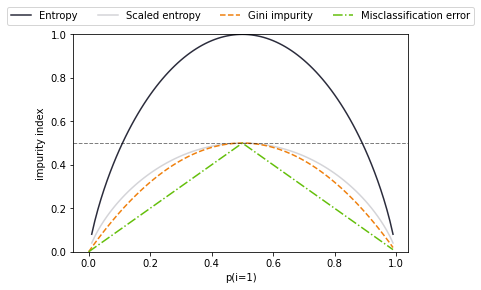

In [2]:
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def gini(p):
    return 1 - (p**2 + (1 - p)**2)

def error(p):
    return 1 - np.max([p, 1 - p], axis=0)

x = np.arange(0, 1, 0.01)
entropy = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in entropy]

ax = plt.subplot(111)
for y, lab, ls, c in zip([entropy, sc_ent, gini(x), error(x)],
                                ['Entropy', 'Scaled entropy', 'Gini impurity', 'Misclassification error'],
                                ['-','-', '--', '-.'],
                                ['#2b2c3c', '#d4d4d8', '#ef800e', '#64bf0b']):
    line = ax.plot(x, y, label=lab, linestyle=ls, color=c)
ax.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--', alpha=0.5)
plt.ylim([0, 1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.show()

## Popular decision tree algorithms
- **ID3** (1986): extension of D3.
- **C4.5** (1993): successor of ID3, it uses *gain ratio* instead of *information gain*.
- **CART** (1984): Classification And Regression Tree, it uses the *Gini index*.
- **CHAID** (1980): CHi-square Automatic Interaction Detection performs multi-level splits when computing classification trees.
- **MARS** (1991): Multivariate Adaptive Regression Splines.

# Main issues
The **greedy strategy** consists into splitting the records based on an attribute test that optimizes a certain criterion.

### How to select the feature to split?
We choose the attribute whose splitting leads to the greatest gain in information, according to a certain measure. For instance, the ID3 algorithm use the information gain as this measure. 

Building a decision tree can be seen as a search in a hypothesis space. The **hypothesis space** searched by ID3 is the set of possible decision trees, that **is a *complete* space of finite discrete-value functions**, relative to the available attributes in the dataset. Thanks to this, it avoids the risk for the hypothesis space of not containing the target function. It performs a simple-to-complex, hill-climbing search through this hypothesis space beginning with the empty tree. The information gain measure is the evaluation function that guides the hill-climbing search. ID3 maintains only a single current hypothesis as it searches through the space of decision trees, differently from *CandidateElimination* algorithm (see the notebook on Concept Learning) which instead maintains the set of all hypotheses consistent with the available training examples. Therefore, ID3 has the limitation of not being able to determine how many alternative decision trees are consistent with the training data. 

#### What is the inductive bias in DT learning?

Since, in general, there are many decision trees consistent with the training set, how do we choose one of the trees over the others? In other words, what is the policy by which a certain DT algorithm generalizes from observed training examples to classify unseen instances?
The **inductive bias** of the ID3 algorithm follows from its search strategy (it chooses the first consistent tree it finds), and, approximately, is: 
- Shorter trees are preferred over longer trees. 
- Trees that place high information gain attributes close to the root are preferred over those that do not.

ID3 searches **incompletely** through a **complete hypothesis space** (a space that is able to represent any finite discrete-valued function over the attributes of the dataset). Its inductive bias is solely a consequence of the ordering of hypotheses by its search strategy. Its hypothesis space introduces no additional bias. 
By preferring certain hypotheses over others, we have a ***preference bias*** (or *search bias*).

On the contrary, the *CANDIDATE-ELIMINATION* algorithm searches **completely** through an **incomplete** hypothesis space (one that can express only a subset of the potentially teachable concepts). Its inductive bias is solely a consequence of the expressive power of its hypothesis representation. Its search strategy introduces no additional bias.
By restricting the set of hypotheses considered, we have a ***restriction bias*** (or *language bias*).

A *preference bias* is preferred over a *restriction bias* because it allows the learner to work within a complete hypothesis space, that is assured to contain the unknown target function.

A rule of thumb is to **prefer the simplest hypothesis that fits the data**.

### How to perform the split

It depends on the type of the attribute (nominal, ordinal, continuous) and on the number of ways to split (2-way split, multi-way split).

- **Nominal attributes** (e.g. `CarType` can be sport/family/luxury) 
    - **Binary split:** the features are divided into two subsets (e.g. along the left branch go the instances with `CarType=family` or `CarType=luxury`, and along the other branch go the instances with `CarType=sport`)  
    - **Multi-way split:** we use as many partitions as the number of different values the attribute can take.
- **Ordinal attributes** (e.g. `Size` can be XS/S/M/L/XL)
    - **Binary split:** the features are divided into two subsets of values that are subsequent with respect to the ordering (e.g. `{XS/S}` and `{M/L/XL}` is a valid split, but `{XS/M}` and `{S/L/XL}` is not
    - **Multi-way split:** we use as many partitions as the number of different values the attribute can take.
- **Continuous attributes** (e.g. height)  
    - **Discretization** to form an ordinal categorical attribute (e.g. short/mid/tall)
    - **Binary decision** according to a certain threshold (this can be more computationally expensive since we must consider all possible splits and select the best one).


### How to handle continuous valued attributes?
For a continuous valued attribute $A$ we can dynamically create a boolean attribute $A_c$

$$A_c = \begin{cases}\texttt{true} & \mathrm{if } A<c \\ \texttt{false} & \mathrm{otherwise}\end{cases}$$

How to select the best threshold value for $c$ is described as follows:
1. Sort the examples according to the value of the continuous valued attribute in consideration.
2. Identify adjacent samples that differ in their target classification.
3. Generate a set of candidate thresholds between the corresponding values of the attribute.
4. Evaluate the thresholds by computing the information gain associated with each of the candidate boolean valued attributes and select the best one.

For example:

|  Height (cm) | 150 | 159 | 174 | 177 | 186 | 190 | 191 |
|--------------|-----|-----|-----|-----|-----|-----|-----|
|    Target    | Yes | Yes | No  | No  | No  | Yes | Yes |

The two candidate thresholds are:
- $c_1=\frac{159+174}{2}= 166.5$
- $c_2=\frac{186+190}{2}= 188$

Then, the candidate boolean attributes are:
- $height_{>166.5}$
- $height_{>188}$

In [3]:
"""Example: identify the candidate thresholds for a continuous valued attribute"""

columns = ('Hair color', 'Height', 'Target')
data = [('Platinum', 190, True),('Dark', 191, True),('Brown', 159, True),('Dark', 177, False),
        ('Dark', 174, False),('Blonde', 186, False),('Blonde', 150, True)]
data = pd.DataFrame.from_records(data, columns=columns)

# sort according to height
data.sort_values('Height', ascending=True, inplace=True)
data = data.reset_index(drop=True)

thresholds = []
for i in range(len(data)-1):
    if (data.at[i,'Target'] != data.at[i+1,'Target']):
        thresholds.append((data.at[i,'Height']+data.at[i+1,'Height'])/2)

display(data)
print('Candidate thresholds:', thresholds)

,Hair color,Height,Target
0,Blonde,150,True
1,Brown,159,True
2,Dark,174,False
3,Dark,177,False
4,Blonde,186,False
5,Platinum,190,True
6,Dark,191,True


Candidate thresholds: [166.5, 188.0]


### When to stop?
The process continues until a **stopping criterion** is reached, for instance:
- No region contains more than `min_samples_split` observations
- `max_tree_depth` has been reached by every branch
- The decrease in the RSS due to each split does not exceeds some threshold
- We stop expanding a node if all of its records belong to the same class
- We stop expanding a node if all of its records have the same attribute values, therefore we are unable to further split that node
- ...

### How to deal with noisy data?
With the term *noisy data* we refer to data entries that are inconsistent. For instance, two identical entries with different target values. To solve this problem is enough to modify the termination criterion to accept hypotheses that imperfectly fit the training data. Furthermore, by considering all the examples at each step of the construction of the tree, and by making decisions based on **statistical properties** (such as information gain), the resulting search is less sensitive to noise in the data.

### How to handle training data with missing attribute values?

There may be different procedures. For example, we might assign to a missing attribute value **the most common value** among examples in the dataset or in the same node that have the **same target value**. 

A different procedure (adopted in C4.5 algorithm) consists into **assigning a probability based on the frequency of the values** for that attribute. For instance consider a boolean valued attribute $f_1$, whose frequencies are `6/9` for $f_1=No$ (calculated by counting the occurences of $f_1=No$ over the total number of rows for which $f_1$ is non-missing) and `3/9` for $f_1=Yes$ (calculated by counting the occurences of $f_1=Yes$ over the total number of rows for which $f_1$ is non-missing).

If we have a training entry for which $f_1$ is missing, then `6/9` of that entry is distributed down the branch for $f_1=No$ and a fractional `3/9` is distributed down the branch for $f_1=Yes$. The fractional examples are then used to compute the information gain.

At the time of testing, a test instance with missing value is split into branches according to the portions of training examples falling into those branches and goes down to leaves.

As an example, consider the following dataset

|   |  f<sub>1</sub> | .. | Target |
|:-:|:---:|:--:|:------:|
| 1 | Yes | .. |   No   |
| 2 |  No | .. |   No   |
| 3 |  No | .. |   No   |
| 4 | Yes | .. |   No   |
| 5 |  No | .. |   Yes  |
| 6 |  No | .. |   No   |
| 7 | Yes | .. |   No   |
| 8 |  No | .. |   Yes  |
| 9 |  No | .. |   No   |
| 10 |  **?** | .. |   Yes   |

Attribute `f1`'s value of the 10-th entry is missing. Therefore, we partially split that entry down the two branches determined by attribute `f1` according to:

- $p(f_1 = Yes) = 3/9$, since of the entries whose $f_1$ value is present, 3 out of 9 have $f_1=Yes$.
- $p(f_1 = No) = 6/9$

Then we make a split on `f1`:
- down the branch `f1 = Yes` we send `3` instances having `Target = No` and `0 + 3/9` instances having `Target = Yes`
- down the branch `f1 = No` we send `4` instances having `Target = No` and `2 + 6/9` instances having `Target = Yes`
More precisely, we assign the 10-th record with weight equal to `3/9` to the child corresponding to `f1 = Yes`, and with weight equal to `6/9` to the child corresponding to `f1 = No`.

If a new instance $(f_1=No, \dots, Target = ?)$ has to be classified, we will need to consider the fact that the number of examples in the node `f1 = No` is `4 + 2 + 6/9 = 6.67`.

### How to handle attributes with different costs?
In some cases, attributes may have a cost associated (quality, comfort, monetary...). In such cases decision trees with low-cost attributes are preferrable, relying on high-cost attributes only when needed to produce reliable classifications. 

Examples of approaches are:

- Tan and Sclimmer (1990): replace the information gain attribute selection measure with:

$$\frac{InfoGain^2(\text{node, attribute})}{\text{Cost(attribute)}}$$

- Nunez (1988): attribute selection measure is:

$$\frac{2^{InfoGain(node, attribute)}-1}{(\text{cost(attribute)}+1)^w}$$

where $w\in [0,1]$ is a constant weighting the relative importance of costs vs information gain.

### How to avoid overfitting?

The main causes of overfitting in decision trees are the presence of noise in the dataset (inconsistent entries), and datasets with a  small number of entries.

There are two main approaches to **avoid overfitting** in decision tree learning.
- approaches that stop growing the tree earlier, before it reaches the point where it perfectly classifies the training data.
- approaches that allow the tree to overfit the data, and then **post-prune** the tree (preferrable approach due to the difficulty in the first approach of estimating precisely when to stop growing the tree).

Regardeless of which of the two approaches we choose to follow, a typical way to determine how deeply to grow the DT is the common **training, validation and test set** approach. The available data is separated into:
- a *training set*, which is used to form the learned hypothesis.
- a *validation set*, which is used to evaluate the impact of pruning this hypothesis.
- a *test set*, which is used to evaluate the accuracy of this hypothesis on new, unseen data.

Then we can use the validation set approach in many ways in order to prune the tree. When the dataset is limited, this approach may not work since we would further reduce the size of the training set. 

#### Reduced error pruning
One way is the **reduced error pruning**: a certain node is removed (making it a leaf node and assigning to it the most common classification of the training examples affiliated with that node) only if the resulting pruned tree performs no worse than the previous one over the validation set. We start from the tree at its maximum size and with the lowest accuracy over the test set. Iteratively, nodes are removed, choosing at each iteration the one whose removal increases the overall accuracy on the validation set the most. We stop when further pruning would decrease the accuracy of the tree over the validation set.

#### Rule post pruning
Another approach is the **rule post pruning**:
1. Infer the decision tree allowing for overfitting
2. Convert the learned tree into an equivalent set of rules
3. Prune (generalize) each rule independently of others (e.g. a rule `if f1=Yes and f2='Green': Target = Yes` would become either `if f1=Yes: Target = Yes` or `if f2='Green': Target = Yes`), depending on which pruning step produced the greatest improvement in estimated rule accuracy.
4. Sort final rules by their estimated accuracy and use them in this order

# Decision Trees in scikit-learn

Class labels: [0 1]
Labels counts in y: [32 64]
Labels counts in y_train: [22 45]
Labels counts in y_test: [10 19]
Accuracy score: 0.8966


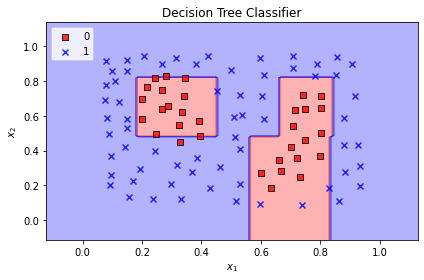

In [4]:
# Read the data
data = np.asarray(pd.read_csv('datasets/decision_tree_data.csv', header=None))
X = data[:,0:2]
y = data[:,2].astype(int)
# split data intro train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print('Class labels:', np.unique(y))
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
# instantiate the classifier
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    splitter='best', 
                                    max_depth=6, 
                                    min_samples_leaf=2,
                                    random_state=1)
# train the classifier
tree_model.fit(X_train,y_train)
# make predictions
y_pred = tree_model.predict(X_test)
# evaluate accuracy score
acc = accuracy_score(y_test, y_pred)
print('Accuracy score: {:.4f}'.format(acc))

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# Plot the result
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model, 
                      test_idx=None, 
                      resolution=0.01)
plt.title('Decision Tree Classifier')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Random forests
Decision trees, despite being easily interpretable and self-explanatory, generally don't have the same level of predictive accuracy as some other models. Furthermore, they can be very non-robust: a small change in the data can cause a large change in the final estimated tree.

Decision trees tend to **overfit** the data, resulting into models that don't generalize well to the data. Main causes of overfitting are usually related to a **high maximum depth** or to a **small minimum number of samples per split**, both of which are parameters that we can specify to our algorithm.
To overcome this problem, **random forests** come to our aid. A random forest is an ensemble of multiple decision trees, each of which suffers from high variance.

**Observation 1:** given a set of *n* independent observations $Z_1,...,Z_n$, each with variance $\sigma^2$, the variance of the mean $\bar{Z}$ of observations is given by $\sigma^2/n$ and so, **averaging a set of observations reduces variance**. This fact leads to the first improvement (called **bootstrap aggregation** or **bagging**) towards a low-variance learning method: take many training sets from the population (or bootstrap, by taking repeated
samples from the single training data set), build a separate prediction model using each training set, and average the resulting predictions.

**Observation 2:** suppose that, in the dataset, there is a very strong predictor (i.e. variable, feature). Each of the bagged trees will use this predictor in the top split, resulting in *highly correlated predictions* from the bagged trees. Averaging highly correlated quantities won't result in a large reduction in variance. To overcome this problem, instead of performing the split at each node over all the *p* predictors, we consider a random subset of *$m\approx \sqrt{p}$* variables. This is a process of *decorrelating the trees*.

The general algorithm is:
1. Draw a random **bootstrap** sample of size $n$ (randomly choose $n$ samples from the dataset with replacement)  
2. Grow a decision tree from the bootstrap sample:  
    a. Randomly select $m$ distinct features.  
    b. Split the node according to the feature that provides the best split (e.g. maximizing the information gain).  
3. Build $k$ decision trees by repeating steps 1 and 2 $k$ times.  
4. **Majority vote:** The overall prediction is the most commonly occurring class among the $k$ predictions, each of which is from one of the trees in the forest.  

Typically, the larger the number of trees, the better the performances of the random forest classifier at the expense of an increased computational cost.

Accuracy score: 0.8621


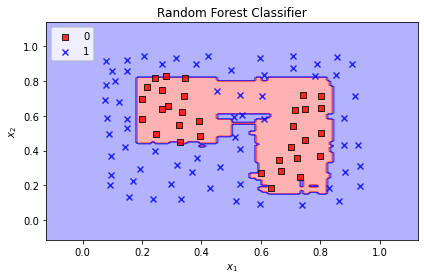

In [5]:
from sklearn.ensemble import RandomForestClassifier
# create a random forest of 'n_estimators' decision trees
forest = RandomForestClassifier(n_estimators = 25,
                                criterion='gini',
                                random_state=1,
                                max_features='sqrt',
                                n_jobs=2)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy score: {:.4f}'.format(acc))

plot_decision_regions(X_combined, y_combined, classifier=forest, resolution=0.01)
plt.title('Random Forest Classifier')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()